# Alireza FarajTabrizi 97102185 HW2 Q1

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 

## Part 1


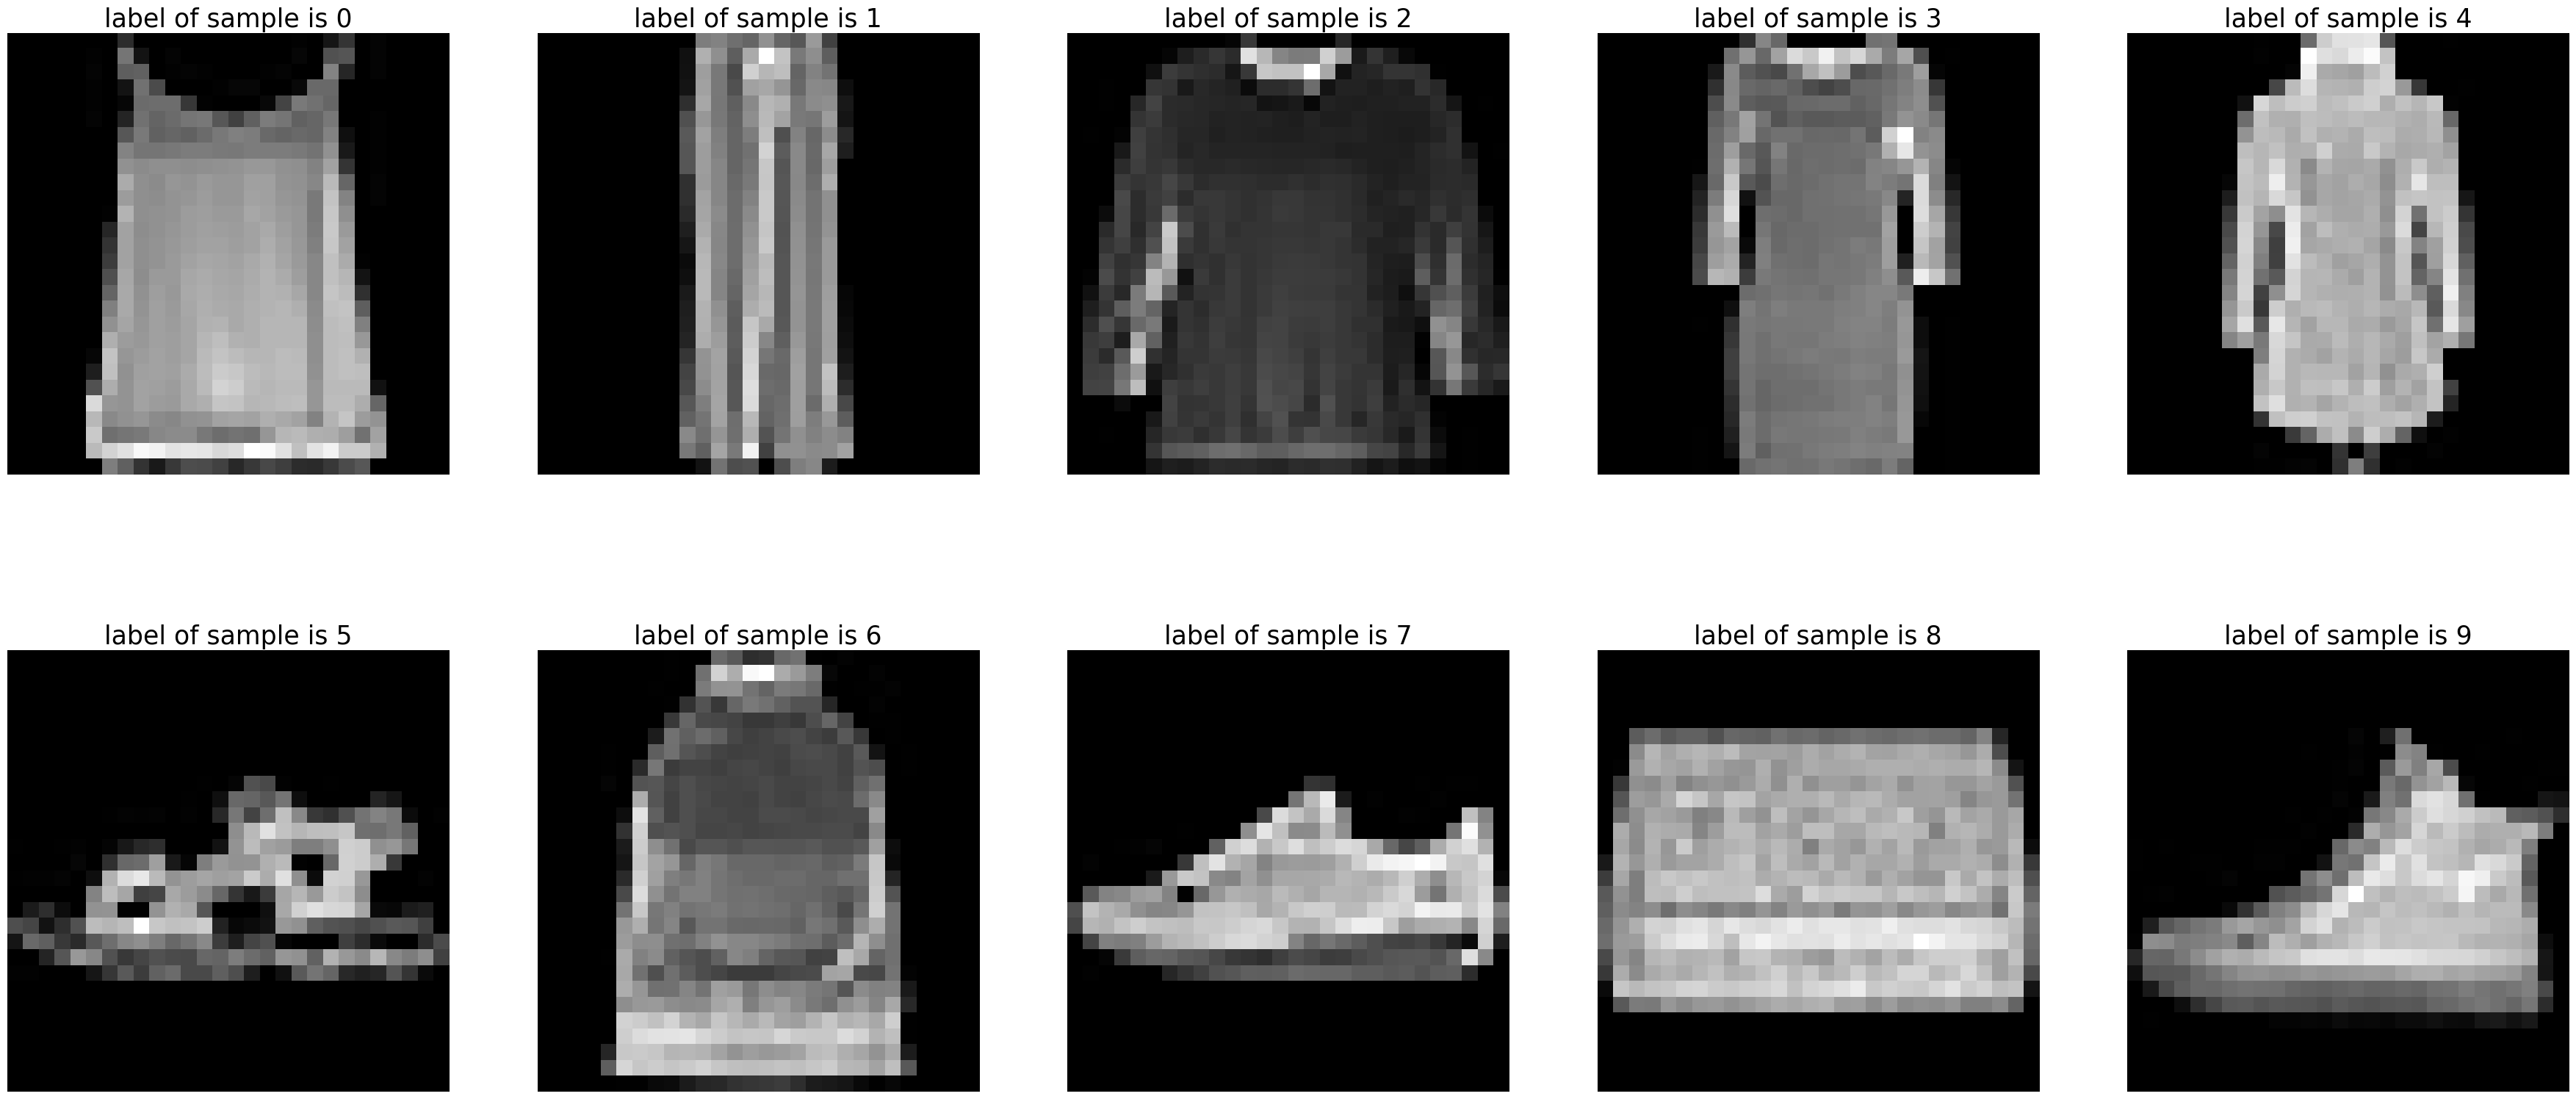

In [26]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
#extracting data from files
train_data = datasets.FashionMNIST(root="data", train=True, download=0, transform=ToTensor())
test_data  = datasets.FashionMNIST(root="data", train=False, download=0, transform=ToTensor())
#######################################################################################################################################
#print  10 different samples from a random batch
train_dataloader = DataLoader(train_data, batch_size=100, shuffle=True)
Xb , y = next(iter(train_dataloader))

plt.figure(figsize=(45,20))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(Xb[y==i][0][0],cmap='gray')
    plt.axis('off')
    plt.title('label of sample is ' + str(i), fontsize=25)

## Part 2

### Activation Functions 

In [27]:
def myrelu(X):
  return (torch.maximum(torch.tensor(0), X))
#######################################################################################################################################
def mysoftmax(X):
  return (torch.exp(X).T/sum(torch.exp(X).T)).T


این قسمت به شکل یک کلاس پیاده سازی شده که با گرفتن تعداد لایه ها، لیستی از تعداد نورون های هر لایه و گرفتن یک لیست از توابع فعال سازی شبکه را می سازد.
تولید بایاس و وزن های اولیه  به صورت رندم با تابع اینیشیت انجام می شود. خروجی این تابع دو لیست است که هر لیست دارای تنسور وزن یا بایاس است.
 تابع دیگر تابع فوروارد است که با گرفتن بچ ورودی خروجی را حساب می کند. مقادیر وزن ها و بایاس ها از بیرون قابل دسترس و تغییر است که در قسمت بهینه سازی لازم می شود. تابعی که در صورت سوال خواسته شده بود تا مدل نام گذاری شود به صورت مدل.فوروارد است 

### Neural Network Class 

In [28]:
class MyNN(object):
  
    def __init__(self, L=5, N=None, actfun=None):
        self.L = L
        self.N = N
        self.actfun = actfun
        if (self.actfun == None):
          self.actfun = [[myrelu]*(self.L-1)] 
        else: self.actfun=actfun
#######################################################################################################################################          
    def initiate(self):
        W = []
        B = []
        total_params = 0
        for l in range(self.L-1):
          w = np.random.normal(0,1/28,(self.N[l],self.N[l+1]))
          b = np.random.normal(0,1/28,(self.N[l+1]))
          w = torch.tensor(w, requires_grad=True).float()
          b = torch.tensor(b, requires_grad=True).float()
          total_params = total_params + self.N[l] * self.N[l+1] + self.N[l+1]
          W.append(w)
          B.append(b)
          self.W = W
          self.B = B
          self.total_params = total_params
####################################################################################################################################### 
    def forward(self,X):
        X=torch.reshape(X,(-1,784))
        Y=[]
        Y.append(X)
    
        for l in range(self.L-1):
          y = self.actfun[l]((Y[l] @ self.W[l]) + self.B[l] )
          Y.append(y)
          
        self.Y=Y
        return Y[self.L-1]    

### an example for my class

In [29]:
k=60

model = MyNN(L=4,N=[784,512,512,1],actfun=[myrelu]*3)
model.initiate()
w,b = model.W , model.B
train_dataloader = DataLoader(train_data, batch_size=k, shuffle=True)
print("Total Parameter of NN :", model.total_params)

Xb , y = next(iter(train_dataloader))

yb = model.forward(Xb)

#y_labled = y_pred.argmax(dim=1)


Total Parameter of NN : 665089


## Part 3

### Loss and Optimization Functions

In [30]:
def MCE(y_pred,grand_truth):
    #in pytorch built-in cross-entropy function it operate a softmax on input first
    #y_pred = mysoftmax(y_pred)
    
    n = grand_truth.shape[0]
    col = np.array(grand_truth) #index of the columns we should use for loss calculation, the rest of columns data is multiplied by 0
    y_tild = y_pred[[range(n),col]]  
    return torch.mean(-torch.log(y_tild))
#######################################################################################################################################
def sgd(w,lr):
    W=[]
    for i in range(len(w)):
        W.append(w[i] - lr*w[i].grad)
    return W 

دو فانکشن زیر همان فانکشن های توتوریال پایتورچ، با مقداری تغییر هستند. مثلا برای رفع اثر گرادیان های قبلی در هر لوپ گرادیان قبلی را از بین می بریم (فور اول در بچ).
بدلیل استفاده از متغیر گردیان درون یک کلاس باید آن را مجددا فرخوانی کنیم تا برای آن گرادیان حساب شود(فور دوم در بچ) و سپس تابع بهینه ساز فراخوانده می شود تا گردیان ها را آپدیت کند. در انتها هم یک دور دیگر تمام بچ ها طی می شوند تا مقادیر خطا و دقت حساب شوند. اگر اینکار در حین فرایند بچ ها انجام می شد مقدار آن، مقدار متوسط خطا و دقت می شد، نه مقدار دقت و خطای هر ایپاک

### Train and Test Loop Functions

In [31]:
def train_loop(dataloader, model, loss_fn, optim,lr):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    
    for batch, (Xb, y) in enumerate(dataloader):
        yb = model.forward(Xb)
        w = model.W
        b = model.B
        
        for i in range(model.L-1):
            w[i].grad = None
            b[i].grad = None
            
        for i in range(model.L-1):
            w[i].retain_grad()
            b[i].retain_grad()
                
        loss = loss_fn(yb,y)
        loss.backward()
        model.W = optim(w,lr)
        model.B = optim(b,lr)
        
        if batch % 100 == 0:
            current =  batch * len(Xb)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
    for Xb, y in dataloader:
        yb = model.forward(Xb)
        train_loss += loss_fn(yb, y).item()
        correct += (yb.argmax(1) == y).type(torch.float).sum().item()
        
    train_loss /= num_batches
    correct /= size
    print(f"Train : Accuracy : {(100*correct):>0.1f}%, loss : {train_loss:>8f}")
#######################################################################################################################################       
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for Xb, y in dataloader:
            yb = model.forward(Xb)
            test_loss += loss_fn(yb, y).item()
            correct += (yb.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test : Accuracy : {(100*correct):>0.1f}%, Avg loss : {test_loss:>8f} \n")
    return 100*correct

### Different Architecture to use (all of them works)

In [32]:
model_0 = MyNN(L=5,N=[784,512,256,64,10],actfun=[myrelu]*3+[mysoftmax])     #4min
model_1 = MyNN(L=4,N=[784,512,512,10],actfun=[myrelu]*2+[mysoftmax])        #4min
model_2 = MyNN(L=5,N=[784,512,512,256,10],actfun=[myrelu]*3+[mysoftmax])    #6.40min


بعد از ده بار ران کردن تمام معماری های بالا 90% آن ها بعد 3 ایپاک به دقت 85 درصد می رسند. سرعت این همگرایی بستگی به مقادیر شروع وزن و بایاس است علت انتخاب لرنینگ ریت 0.1 نیز کم کردن وابستگی به همان نقطه شروع است که عالی عمل کرد زیرا برای 0.01 50 درصد مواقع در ایپاک های کم همگرا می شد. از طرفی چون باید لرنینگ ریت ثابت باشد و امکان اینکه بعدا آن را کاهش دهیم نیست 0.1 بهترین انتخاب است

In [33]:
# You are allowed to change below parameters but you better not change learning rate(it might end up not converging or at least not fast enough)
learning_rate = 1e-1
batch_size = 60
epochs = 3
model = model_0
###############################################################################################################################################
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=batch_size, shuffle=True)

model.initiate()

for e in range(epochs):
    print("_____________________________________________")
    print(f"Epoch {e+1}\n_____________________________________________")
    train_loop(train_dataloader, model, MCE, sgd,learning_rate)
    acu = test_loop(test_dataloader, model, MCE)
print("Total Number of Weights and biases :",model.total_params)
print("Done!")

_____________________________________________
Epoch 1
_____________________________________________
Train : Accuracy : 84.1%, loss : 0.443884
Test : Accuracy : 83.1%, Avg loss : 0.476821 

_____________________________________________
Epoch 2
_____________________________________________
Train : Accuracy : 86.3%, loss : 0.369730
Test : Accuracy : 85.0%, Avg loss : 0.414239 

_____________________________________________
Epoch 3
_____________________________________________
Train : Accuracy : 86.5%, loss : 0.361838
Test : Accuracy : 85.0%, Avg loss : 0.418108 

Total Number of Weights and biases : 550346
Done!


## Part 4

## Testing Model

my Model Accuracy is : 85.02 %


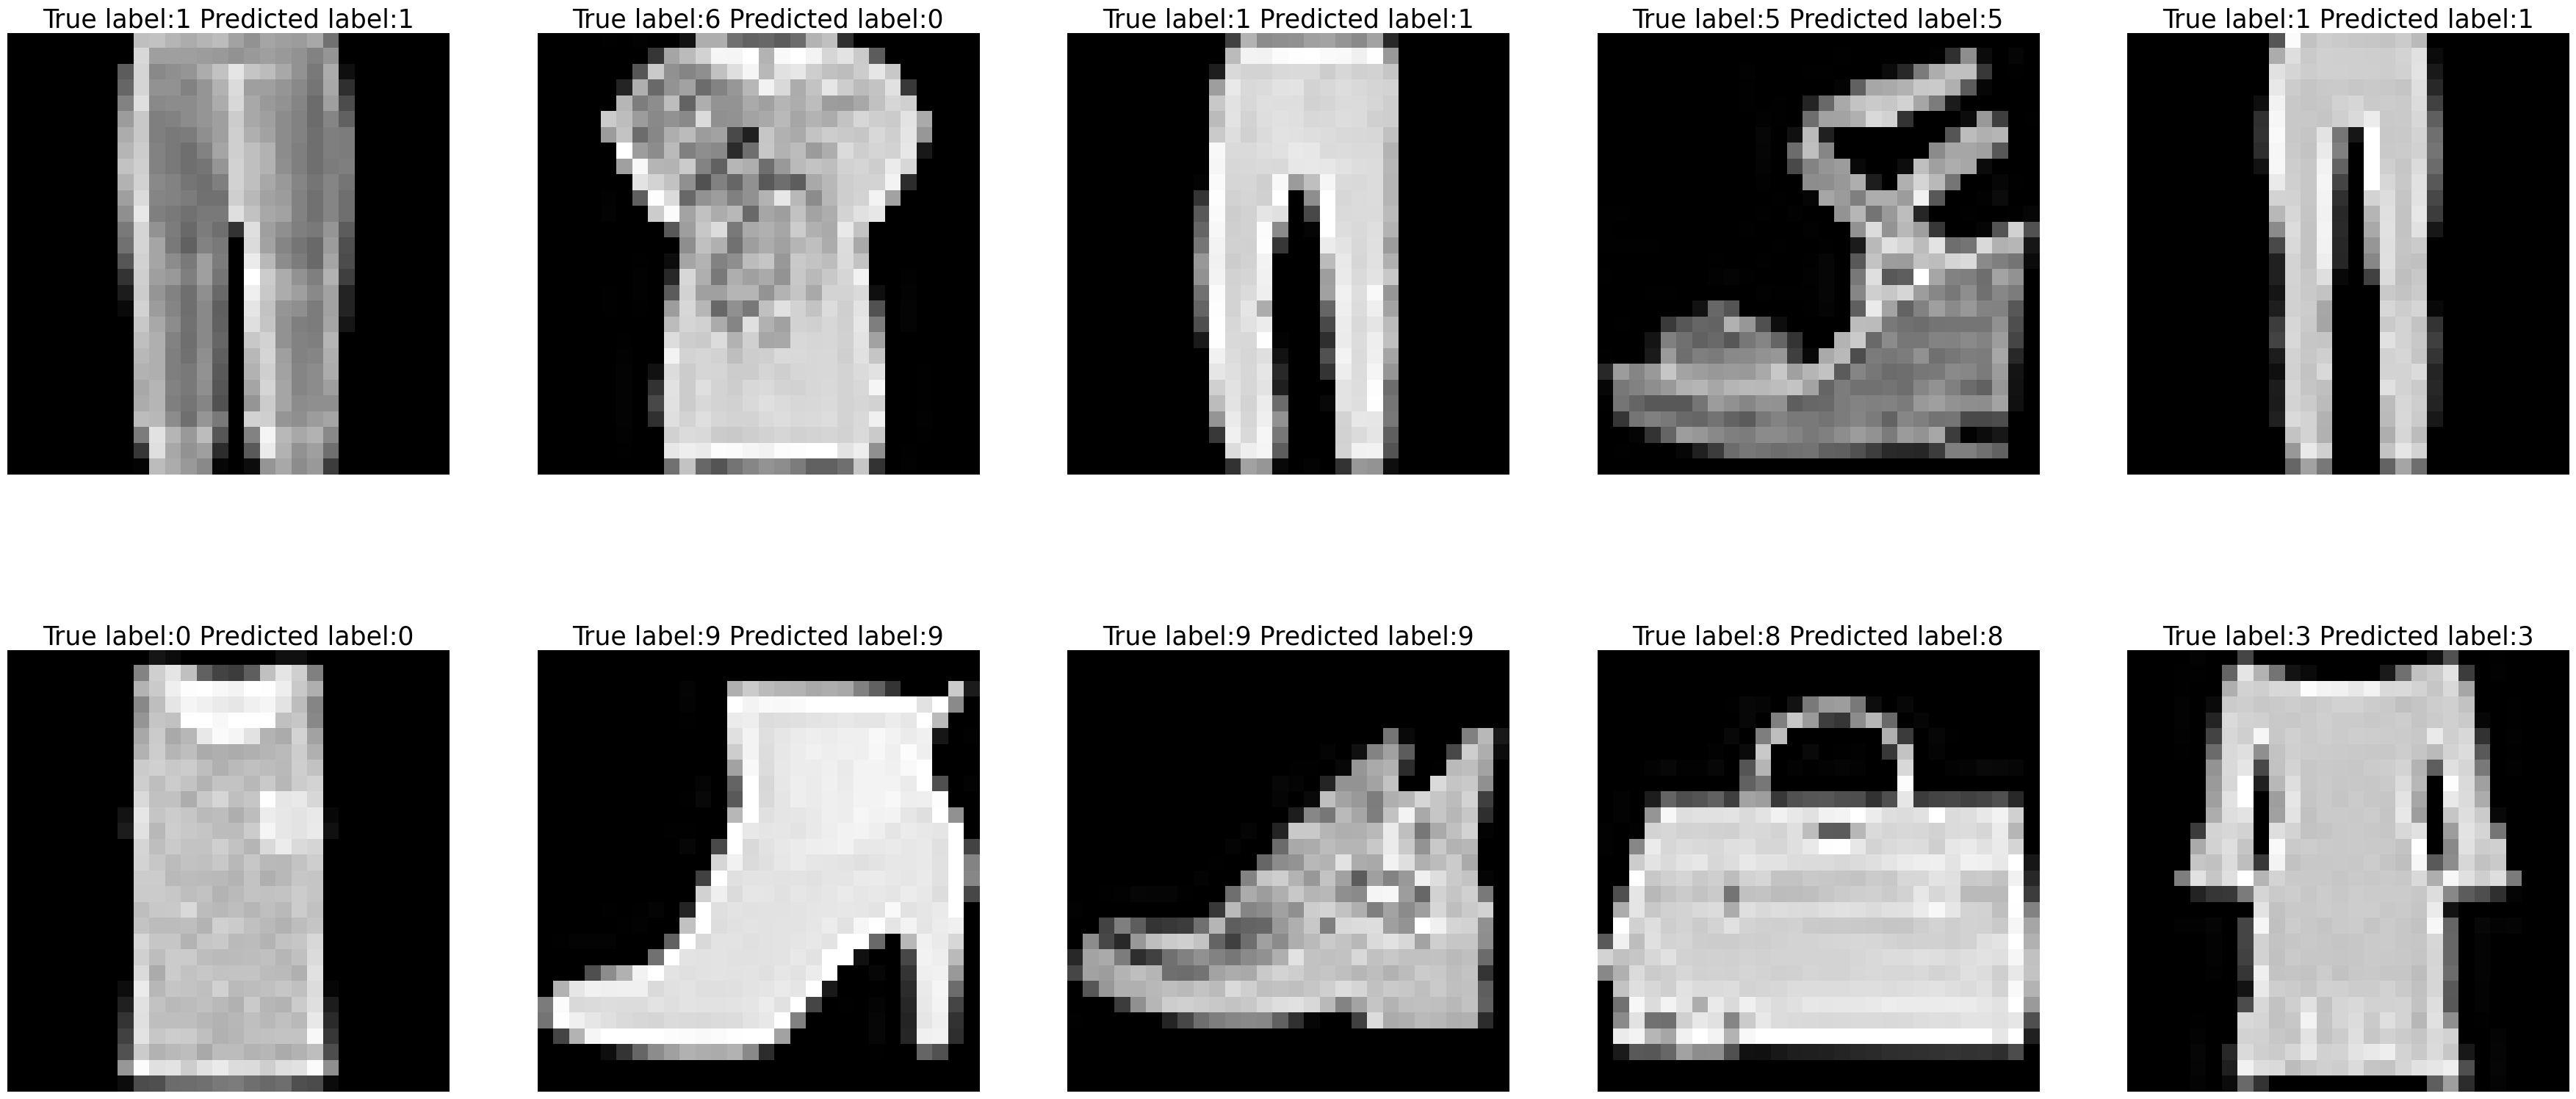

In [34]:
print("my Model Accuracy is :",acu,"%")

sample=np.random.randint(0,len(test_data),size=10)

plt.figure(figsize=(45,20))
for i in range(10):
    n = sample[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(test_data[sample[i]][0][0],cmap='gray')
    plt.axis('off')
    plt.title("True label:" + str(test_data[n][1]) + " Predicted label:" + str(model.forward(test_data[n][0][0]).argmax(1).item()), fontsize=25)